In [36]:
#=
using Pkg
Pkg.add("CSV")
Pkg.add("OrdinaryDiffEq")
Pkg.add("StatsPlots")
Pkg.add("Turing")
=#

In [1]:
using ModelingToolkit, DifferentialEquations, Random, Distributions, Plots, CSV, OrdinaryDiffEq, StatsPlots, Turing, DataFrames
using Random; Random.seed!(2)

data = CSV.read("out.csv", DataFrame)
typeof(data)

df1=Matrix(data)

df1[4, [2,3]]
#data01 = [data[:,2] data[:,3]]

2-element Vector{Float64}:
 0.32056227057666764
 3.7251478008174597

In [2]:
@parameters Vm_GPI Vm_PFKM Vm_ALD Keq_GPI Keq_PFKM Keq_ALD
#=
Keq_GPI = 0.5
Keq_PFKM = 1
Keq_ALD = 0.02
=#

C_G6P = 0.5
C_GAP = 0.3

Kf_GPI = 0.3
Kr_GPI = 0.123
Kf_PFKM = 0.3
Kr_PFKM = 0.123
Kf_ALD = 0.3
Kr_ALD = 0.123

@variables t f6p(t) f16bp(t)
D = Differential(t)

r_GPI = (Vm_GPI/Kf_GPI)*(C_G6P-(f6p/Keq_GPI))/(1 + C_G6P/Kf_GPI + f6p/Kr_GPI)

r_PFKM = (Vm_PFKM/Kf_PFKM)*(f6p-(f16bp/Keq_PFKM))/(1 + f6p/Kf_PFKM + f16bp/Kr_PFKM)

r_ALD = (Vm_ALD/Kf_ALD)*(f16bp-(C_GAP/Keq_ALD))/(1 + f16bp/Kf_ALD + C_GAP/Kr_ALD)

eqs = [D(f6p) ~ r_GPI - r_PFKM,
    D(f16bp) ~ r_PFKM - r_ALD]

@named sys = ODESystem(eqs, t)

sys=structural_simplify(sys)

Model sys with 2 equations
Unknowns (2):
  f6p(t)
  f16bp(t)
Parameters (6):
  Keq_GPI
  Vm_GPI
  Vm_PFKM
  Keq_PFKM
⋮
Incidence matrix:2×4 SparseArrays.SparseMatrixCSC{Num, Int64} with 6 stored entries:
 ×  ×  ×  ⋅
 ×  ×  ⋅  ×

In [15]:
u0 = [f6p => 1*10^-1,
    f16bp => 1*10^-1]
#=
Vm = [Vm_GPI => 5,
    Vm_PFKM => 2,
    Vm_ALD => 3]
=#

Vm = [Vm_GPI => 1,
    Vm_PFKM => 1,
    Vm_ALD => 1]

Keq = [Keq_GPI => 0.5,
    Keq_PFKM => 1,
    Keq_ALD => 0.02]

p= [Vm 
    Keq]


6-element Vector{Pair{Num, Float64}}:
   Vm_GPI => 1.0
  Vm_PFKM => 1.0
   Vm_ALD => 1.0
  Keq_GPI => 0.5
 Keq_PFKM => 1.0
  Keq_ALD => 0.02

In [16]:

tspan = (0.0, 10)
prob = ODEProblem(sys, u0, tspan, p, jac = true)

#=
sol = solve(prob, Rodas4())
sol = solve(prob, Rodas4(); p = p, saveat = 0.1)
print(sol[end])
ss = sol[end]
plot(sol,
    xlim = (0.0, 10),
    xlabel = "Time (h)",
    ylabel = "Concentration (mM)")
=#

#=
df = DataFrame(sol)
CSV.write("out.csv", df)
=#



ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 10.0)
u0: 2-element Vector{Float64}:
 0.1
 0.1

In [149]:
#=
VM01 =[Vm_GPI => rand(LogNormal(log(5), 1),1)[1],
    Vm_PFKM => rand(LogNormal(log(2), 0.5),1)[1], 
    Vm_ALD => rand(LogNormal(log(3), 0.5),1)[1]]

sigma = rand(Uniform(0, 1),1)
p=VM01
=#

In [150]:
#=
sol = solve(prob, Rodas4(); p = p, saveat = 0.1)
=#

In [13]:
Vm_GPI ~ LogNormal(log(5), 1) 
Vm_PFKM ~ LogNormal(log(2), 0.5) 
Vm_ALD ~ LogNormal(log(3), 0.5) 
#sigma ~ Uniform(0, 1)
p=[Vm_GPI, Vm_PFKM, Vm_ALD]

3-element Vector{Num}:
 Vm_GPI
   Vm_PFKM
 Vm_ALD

In [17]:
@model function mymodel(data, prob)
    Vm_GPI ~ LogNormal(log(5), 1) 
    Vm_PFKM ~ LogNormal(log(2), 0.5) 
    Vm_ALD ~ LogNormal(log(3), 0.5) 
    sigma ~ Uniform(0, 1)
    p=[Vm_GPI, Vm_PFKM, Vm_ALD]
    p1 = [p
        Keq]
    sol = solve(prob, Rodas4(); p = p1, saveat = 0.1)
    for i in 1:length(sol)
        data[i,[2,3]] ~ MvNormal(sol[i], sigma)
    end
end

mymodel (generic function with 2 methods)

In [18]:

model = mymodel(df1, prob)

sampler = NUTS()

samples = 1000

chain = sample(model, sampler, samples)


Sampling   0%|█                                         |  ETA: N/A
┌ Warning: Using arrays or dicts to store parameters of different types can hurt performance.
│ Consider using tuples instead.
└ @ SciMLBase C:\Users\alber\.julia\packages\SciMLBase\NjslX\src\performance_warnings.jl:33
Sampling 100%|██████████████████████████████████████████| Time: 0:00:06


MethodError: MethodError: no method matching /(::Float64, ::Pair{Num, Float64})

Closest candidates are:
  /(!Matched::MutableArithmetics.Zero, ::Any)
   @ MutableArithmetics C:\Users\alber\.julia\packages\MutableArithmetics\xVyia\src\rewrite.jl:70
  /(::Any, !Matched::ChainRulesCore.NotImplemented)
   @ ChainRulesCore C:\Users\alber\.julia\packages\ChainRulesCore\zgT0R\src\tangent_types\notimplemented.jl:43
  /(!Matched::ChainRulesCore.NotImplemented, ::Any)
   @ ChainRulesCore C:\Users\alber\.julia\packages\ChainRulesCore\zgT0R\src\tangent_types\notimplemented.jl:42
  ...


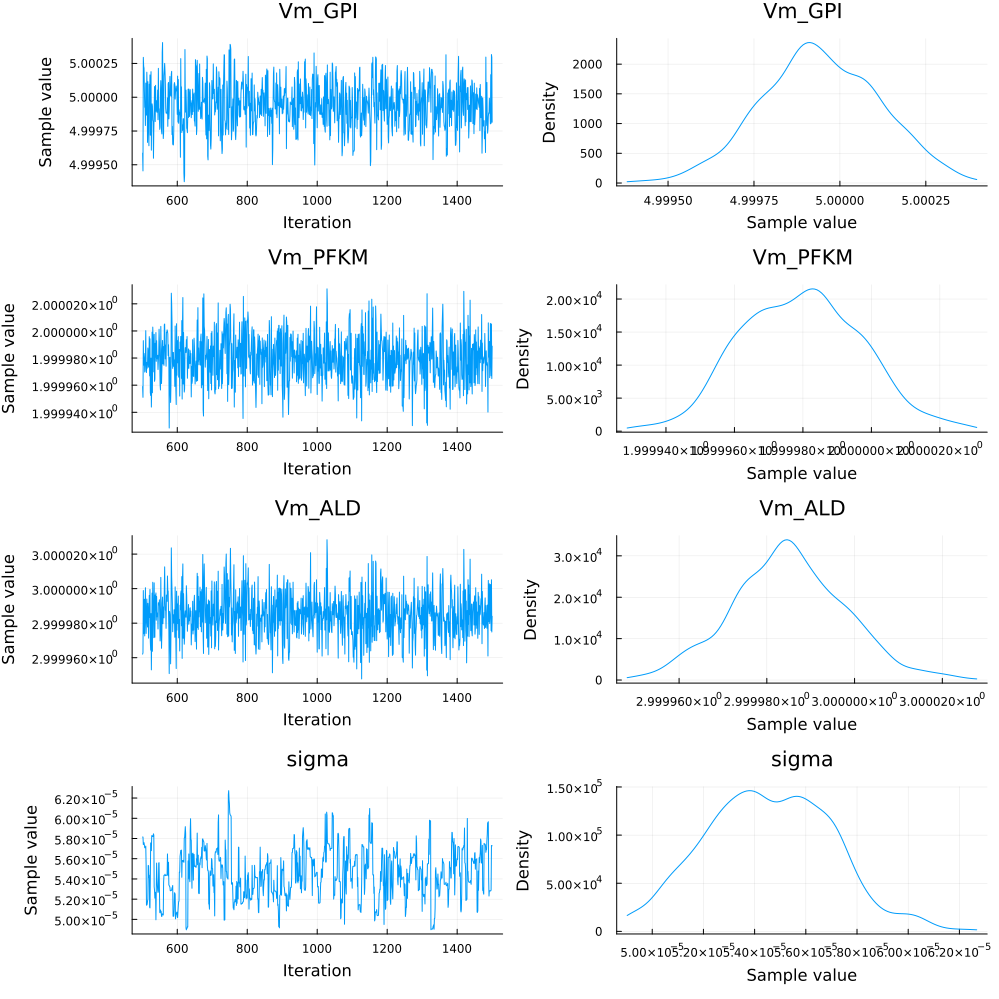

In [153]:
# visualize results

plot(chain)